<a href="https://colab.research.google.com/github/teteumac/ML_Alabama/blob/main/ParticleImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

Machine Learning algorithms have become an increasingly important tool for analyzing the data from the Large Hadron Collider (LHC). Identification of particles in LHC collisions is an important task of LHC detector reconstruction algorithms.

Here we present a challenge where one of the detectors (the Electromagnetic Calorimeter or ECAL) is used as a camera to analyze detector images from two types of particles: electrons and photons that deposit their energy in this detector.

**Dataset**

Each pixel in the image corresponds to a detector cell, while the intensity of the pixel corresponds to how much energy is measured in that cell. Timing of the energy deposits are also available, though this may or may not be relevant. The dataset contains 32x32 Images of the energy hits and their timing (channel 1: hit energy and channel 2: its timing) in each calorimeter cell (one cell = one pixel) for the two classes of particles: Electrons and Photons. The dataset contains around four hundred thousand images for electrons and photons. Please note that your final model will be evaluated on an unseen test dataset.

**Algorithm**

Please use a Machine Learning model of your choice to achieve the highest possible classification performance on the provided dataset. Please provide a Jupyter Notebook that shows your solution.

Evaluation Metrics
ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)
Training and Validation Accuracy
The model performance will be tested on a hidden test dataset based on the above metrics.

**Deliverables**

Google Colab Jupyter Notebook showing your solution along with the final model accuracy (Training and Validation), ROC curve and AUC score. More details regarding the format of the notebook can be found in the sample Google Colab notebook provided for this challenge.
The final trained model including the model architecture and the trained weights ( For example: HDF5 file, .pb file, .pt file, etc. ). You are free to choose Machine Learning Framework of your choice.


<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/UAPH4582/PH482_582_Sp22/blob/main/Hackathons/Hackathon-02/Hackathon-02.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Create the appropriate project folder 

In [1]:
mkdir Particle_Images

In [2]:
cd Particle_Images

/content/Particle_Images


In [3]:
mkdir data/

# Download the Dataset
This will download 83MB for SingleElectron and 76MB for SinglePhoton.

In [4]:
#!/bin/bash
!wget https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download -O data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
!wget https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download -O data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

--2022-03-31 17:19:44--  https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 188.184.97.72, 128.142.53.35, 128.142.170.17, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|188.184.97.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87010508 (83M) [application/octet-stream]
Saving to: ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’

data/SingleElectron 100%[===================>]  82.98M   108MB/s    in 0.8s    

Last-modified header invalid -- time-stamp ignored.
2022-03-31 17:19:46 (108 MB/s) - ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’ saved [87010508/87010508]

--2022-03-31 17:19:46--  https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 188.184.97.72, 128.142.53.35, 128.142.170.17, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|188.184.97.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79876391 (76M

# Import modules

In [5]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import h5py
from keras.models import Sequential
from keras.initializers import TruncatedNormal
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

In [6]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Keras Model Parameters

In [7]:
rate_data   = 0.5
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 64       # Training batch size
train_size  = int(160000*rate_data)   # Training size, max is 160000
valid_size  = int(44800*rate_data)    # Validation size, max is 44800
test_size   = 1024     # Test size
epochs      = 20       # Number of epochs

It is recommended to use GPU for training and inference if possible.

# Load Image Data
- Two classes of particles: electrons and photons
- 32x32 matrices (two channels - hit energy and time) for the two classes of particles electrons and photons impinging on a calorimeter (one calorimetric cell = one pixel).
- Note that although timing channel is provided, it may not necessarily help the performance of the model.

In [8]:
img_rows, img_cols, nb_channels = 32, 32, 2        
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

# Configure Training / Validation / Test Sets

In [9]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available


# Plot sample of training images
Note that although the timing channel is provided, it may not necessarily help the performance of the model.

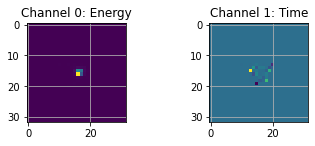

In [10]:
plt.figure(1)

plt.subplot(221)
plt.imshow(X_train[1,:,:,0])
plt.title("Channel 0: Energy")  # Energy
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[1,:,:,1])
plt.title("Channel 1: Time")  # Time
plt.grid(True)


plt.show()

# Define CNN Model
This is a sample model. You can experiment with the model and try various architectures and other models to achieve the highest possible performance.  

In [11]:
### Define Convolutional Neural Network (CNN) Model ###
def build_model(hp):
  model = Sequential()
  model.add(Conv2D(hp.Int("filters", 16, 128, step=16), activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal', input_shape=(img_rows, img_cols, nb_channels)))
  model.add(Conv2D(hp.Int("filters", 16, 128, step=16), activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(2*hp.Int("filters", 32, 256, step=32), activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
  model.add(Conv2D(2*hp.Int("filters", 32, 256, step=32), activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(keras.layers.BatchNormalization())
  model.add(Dense(units=2*hp.Int("units", 128, 512, step=32), activation='relu', kernel_initializer='TruncatedNormal'))
  #if hp.Boolean("dropout"):
  model.add(Dropout(0.5))
  model.add(keras.layers.BatchNormalization())
  model.add(Dense(units=hp.Int("units", 128, 512, step=32), activation='relu', kernel_initializer='TruncatedNormal'))
  #if hp.Boolean("dropout"):
  model.add(Dropout(0.25))
  model.add(Dense(1, activation='sigmoid', kernel_initializer='TruncatedNormal'))
  model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

  return model


In [12]:
'''
model = Sequential()
model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal', input_shape=(img_rows, img_cols, nb_channels)))
model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid', kernel_initializer='TruncatedNormal'))
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()'''

'\nmodel = Sequential()\nmodel.add(Conv2D(16, activation=\'relu\', kernel_size=3, padding=\'same\', kernel_initializer=\'TruncatedNormal\', input_shape=(img_rows, img_cols, nb_channels)))\nmodel.add(Conv2D(16, activation=\'relu\', kernel_size=3, padding=\'same\', kernel_initializer=\'TruncatedNormal\'))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Conv2D(32, activation=\'relu\', kernel_size=3, padding=\'same\', kernel_initializer=\'TruncatedNormal\'))\nmodel.add(Conv2D(32, activation=\'relu\', kernel_size=3, padding=\'same\', kernel_initializer=\'TruncatedNormal\'))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Flatten())\nmodel.add(Dense(1024, activation=\'relu\', kernel_initializer=\'TruncatedNormal\'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(512, activation=\'relu\', kernel_initializer=\'TruncatedNormal\'))\nmodel.add(Dropout(0.25))\nmodel.add(Dense(1, activation=\'sigmoid\', kernel_initializer=\'TruncatedNormal\'))\nmodel.compile(loss=\'binary_crossentropy\', opt

In [13]:
# Initialize the `HyperParameters` and set the values.
!pip install -q -U keras-tuner
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers

hp = kt.HyperParameters()
model = build_model(hp)
model.summary()

     |████████████████████████████████| 133 kB 12.6 MB/s 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        304       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0        

In [14]:
tuner = kt.RandomSearch(
    build_model,
    max_trials=15,
    # Do not resume the previous search in the same directory.
    overwrite=True,
    objective="val_accuracy",
    # Set a directory to store the intermediate results.
    directory="/tmp/tb",
)
'''
history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        verbose=1, shuffle=True)
'''


'\nhistory=model.fit(X_train, y_train,        batch_size=batch_size,        epochs=epochs,        validation_data=(X_valid, y_valid),        verbose=1, shuffle=True)\n'

In [ ]:
tuner.search(
    X_train,
    y_train,shuffle=True,
    validation_data=(X_valid, y_valid),
    epochs=2,
    # Use the TensorBoard callback.
    # The logs will be write to "/tmp/tb_logs".
    callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")],
)

Trial 20 Complete [00h 07m 24s]
val_accuracy: 0.5033705234527588

Best val_accuracy So Far: 0.6856138110160828
Total elapsed time: 03h 03m 00s

Search: Running Trial #21

Value             |Best Value So Far |Hyperparameter
64                |16                |filters
512               |128               |units

Epoch 1/2
10000/10000 [==============================] - 256s 25ms/step - loss: 0.6181 - accuracy: 0.6673 - val_loss: 7.0850 - val_accuracy: 0.5000
Epoch 2/2
 1343/10000 [===>..........................] - ETA: 3:25 - loss: 0.5888 - accuracy: 0.6972

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

## Train the Model
You may further optimize the model, tune hyper-parameters, etc. accordingly to achieve the best performance possible.

In [ ]:
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-6)

model = tuner.hypermodel.build(best_hps)
history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        verbose=1, shuffle=True)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, batch_size=batch_size, validation_data=(X_valid, y_valid))

## Evaluate the Model  
Along with the model accuracy, the prefered metric for evaluation is ROC (Receiver Operating Characteristic) curve and the AUC score (Area under the ROC Curve).

In [ ]:
# Evaluate on validation set
score = hypermodel.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = hypermodel.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = hypermodel.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = hypermodel.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Submission format: 
Submit the Google Colab Jupyter Notebook demonstrating your solution in the similar format as illustrated in this notebook. It should contain:
*   The final model architecture, parameters and hyper-parameters yielding the best possible performance,
*   Its Training and Validation accuracy, 
*   ROC curve and the AUC score as shown above.
*   Also, please submit the final trained model containing the model architecture and its trained weights along with this notebook (For example: HDF5 file, .pb file, .pt file, etc.). Either in this notebook or in a separate notebook show how to load and use your model.

Save the training model Neural Network in .h5 file 

In [ ]:
import h5py
prefixy_NN = "output_NeuralNetwork"
with h5py.File( prefixy_NN +'.h5', 'w') as f:
   dset = f.create_dataset( 'NN', data = hypermodel )

Open .h5 file

In [ ]:
def open_file( path_file ):
    with h5py.File( path_file , 'r' ) as f:
        model_training_NN = f['NN']
        return model_training_NN